## Create dataframe

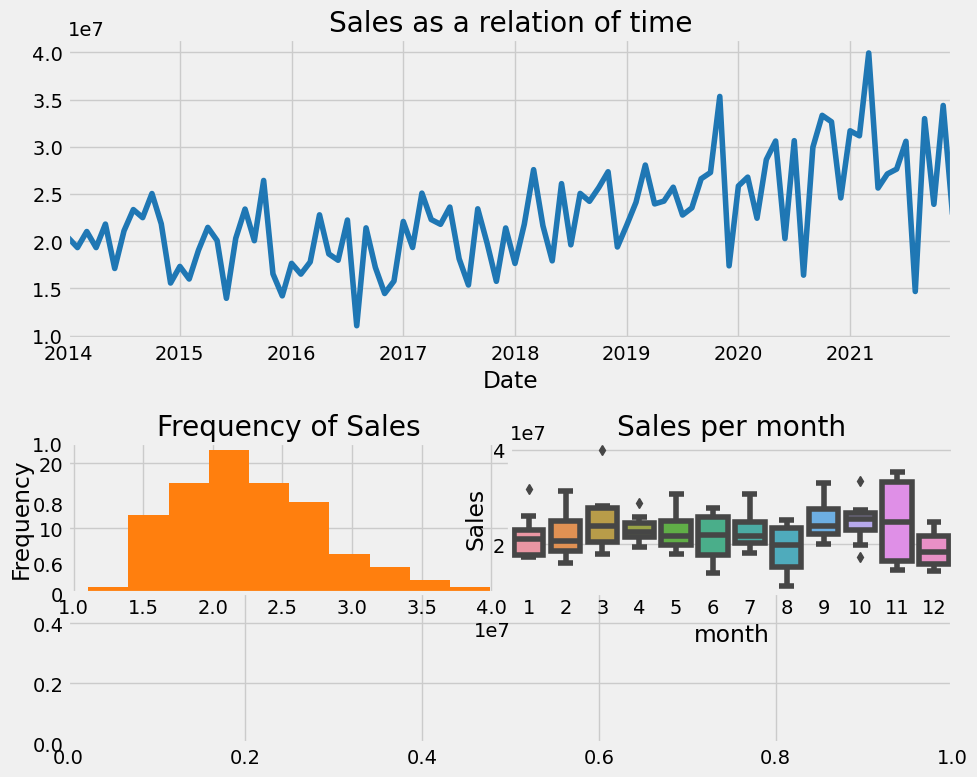

,Sales,quarter,month,lag1,lag2,lag3
Date,,,,,,
2014-07-01,21100263.32,3,7,21026006.52,19325573.70,20375147.15
2014-08-01,23348085.73,3,8,19323056.76,21026006.52,19325573.70
2014-09-01,22493683.18,3,9,21812402.79,19323056.76,21026006.52
2014-10-01,25046267.60,4,10,17112150.55,21812402.79,19323056.76
2014-11-01,21840303.11,4,11,21100263.32,17112150.55,21812402.79
...,...,...,...,...,...,...
2021-08-01,14678815.32,3,8,25629571.70,39928890.67,31157786.40
2021-09-01,32975860.80,3,9,27122135.03,25629571.70,39928890.67
2021-10-01,23905648.49,4,10,27635966.69,27122135.03,25629571.70


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from timeseries_boosted import  createTimeSeriesDf, plotDataSummary, addLags
from sklearn.model_selection import TimeSeriesSplit

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

features = ['quarter', 'month', 'lag1','lag2','lag3']
target = 'Sales'
cutoffDate = '01-01-2020'

df = createTimeSeriesDf('C:/Users/janyl/safemed_2.xlsx')
plotDataSummary(df)
plt.show()
df = addLags(df)
df = df.dropna()
df

## Train on dataset

In [95]:
train = df.loc[df.index < cutoffDate]
test = df.loc[df.index >= cutoffDate]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_all = df[features]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=500,
                        early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=5,
                        learning_rate=0.01)
reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=10);

[0]	validation_0-rmse:21345488.70289	validation_1-rmse:28065299.63530
[10]	validation_0-rmse:19416665.65796	validation_1-rmse:26137192.98441
[20]	validation_0-rmse:17677852.10650	validation_1-rmse:24396864.44852
[30]	validation_0-rmse:16111852.08713	validation_1-rmse:22826666.28131
[40]	validation_0-rmse:14703122.18114	validation_1-rmse:21410572.84617
[50]	validation_0-rmse:13435009.14055	validation_1-rmse:20049100.81377
[60]	validation_0-rmse:12289839.75012	validation_1-rmse:18775433.34136
[70]	validation_0-rmse:11256634.06920	validation_1-rmse:17635143.65560
[80]	validation_0-rmse:10323235.63679	validation_1-rmse:16592616.76783
[90]	validation_0-rmse:9479596.71777	validation_1-rmse:15630761.23513
[100]	validation_0-rmse:8715371.55446	validation_1-rmse:14771565.26602
[110]	validation_0-rmse:8024717.67541	validation_1-rmse:13994478.57783
[120]	validation_0-rmse:7400288.89265	validation_1-rmse:13297948.25880
[130]	validation_0-rmse:6825708.04028	validation_1-rmse:12645547.68405
[140]	va

## Predict & Plot the fitted data

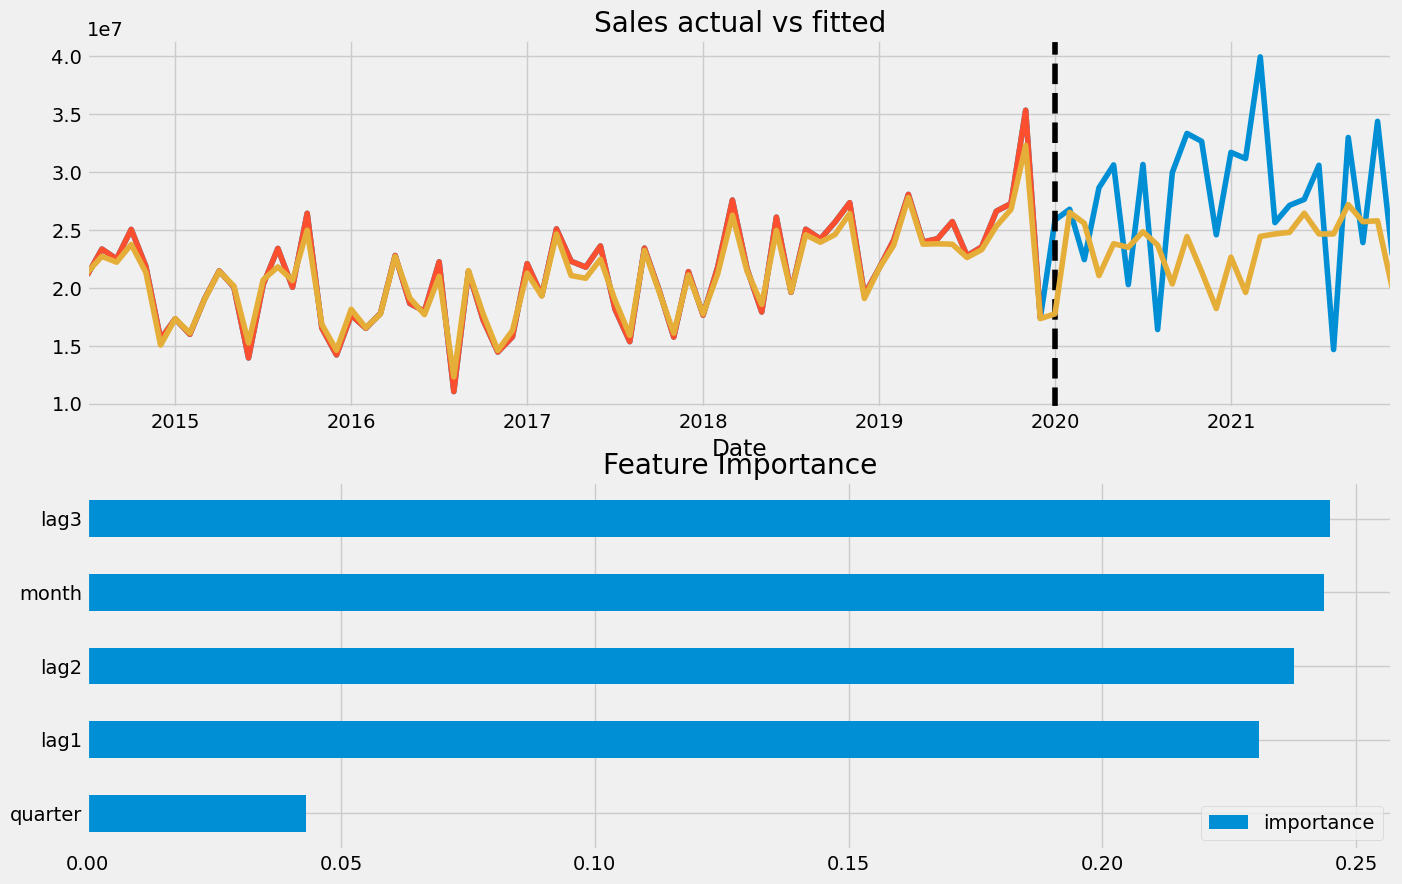

In [96]:
y_pred = reg.predict(X_all)
df['pred'] = y_pred

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
df['Sales'].plot(ax=ax[0],
                        label='Actual',
                        title=f'Sales actual vs fitted')
train['Sales'].plot(ax=ax[0], label='train')
ax[0].axvline(cutoffDate, color='black', ls='--')
df['pred'].plot(ax=ax[0],
                        label='Fit')

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', ax=ax[1])
plt.show()

## Predict the future

In [127]:
X_all = df[features]
y_all = df[target]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=5,
                        learning_rate=0.01)
reg.fit(X_all, y_all,
            eval_set=[(X_all, y_all), (X_all, y_all)],
            verbose=False);

future = pd.date_range(df.index.max() + pd.offsets.MonthBegin(1), periods = 4, freq='MS')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_and_future = pd.concat([df, future_df])
df_and_future['isFuture'] = df_and_future['isFuture'].fillna(False)

df_and_future = addLags(df_and_future)
X_all_and_future = df_and_future[features]
y_all_and_future = df_and_future[target]
df_and_future['pred'] = reg.predict(X_all_and_future)
df_and_future
future_df = df_and_future.query('isFuture').copy()


## Plot future

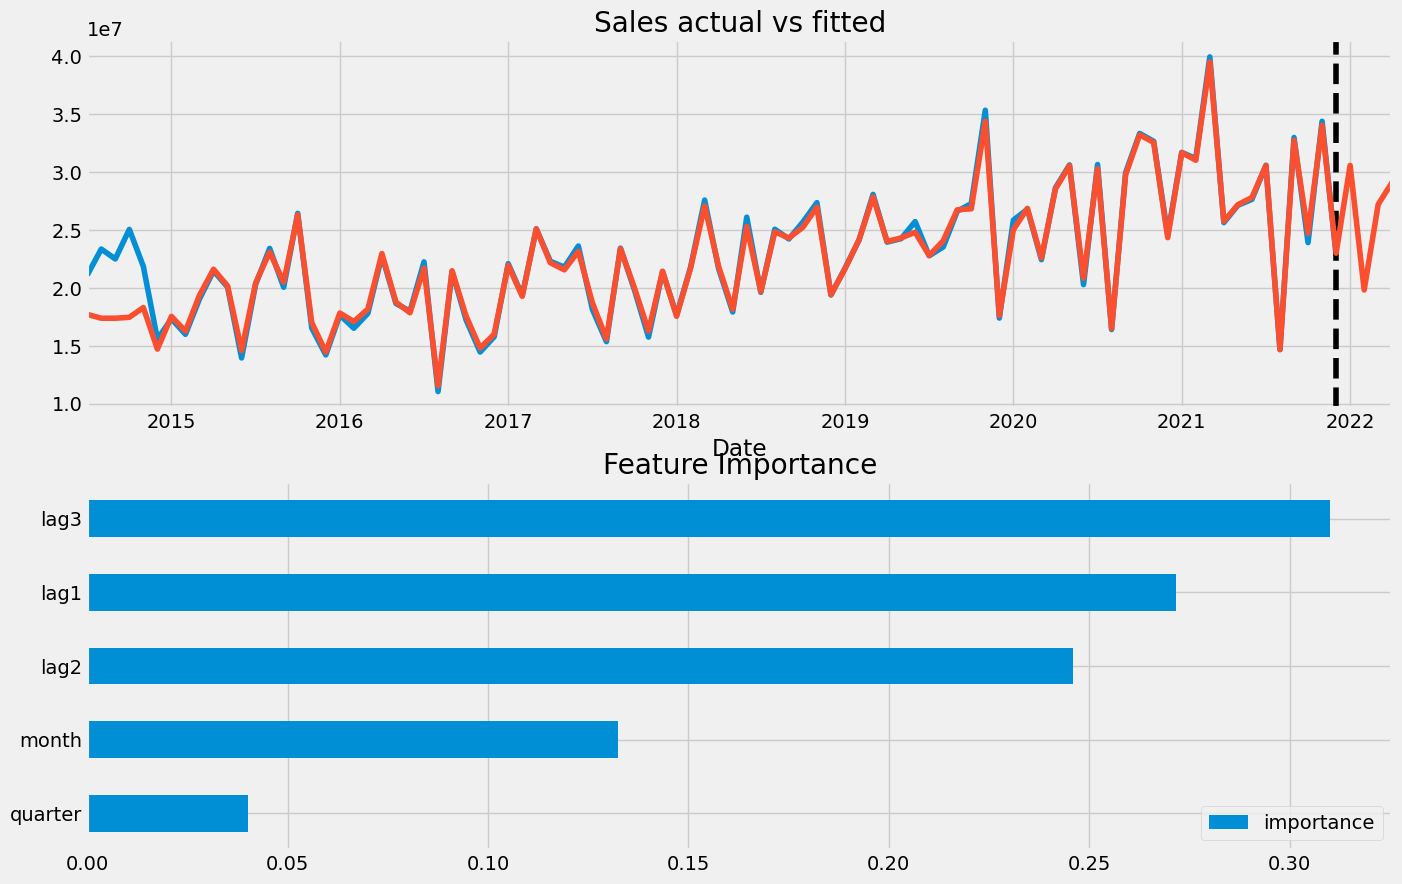

In [126]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
df['Sales'].plot(ax=ax[0],
                        label='Existing',
                        title=f'Sales actual vs fitted')
ax[0].axvline(df.index.max(), color='black', ls='--')
df_and_future['pred'].plot(ax=ax[0],
                        label='Prediction')

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', ax=ax[1])
plt.show()